In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from pathlib import Path
from math import trunc
from scipy import optimize
import copy
%matplotlib inline

SMALL_SIZE = 10*2                                        
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 14*2

plt.rc('font', size=SMALL_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)                     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE/1.2)                    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
plt.rc('figure', figsize='8, 6')                         # size of the figure, used to be '4, 3' in inches

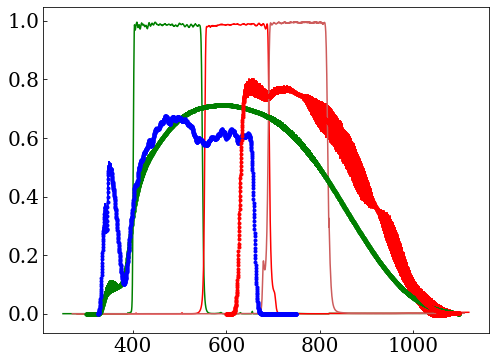

Refractive index silicate = 1.45735


In [2]:
def hulst(a,wl):
    n = n_silicate
    p = 4*np.pi*a*(n-1)/wl
    return 2 - ((4/p)*np.sin(p)) + (4/(p**2)*(1-np.cos(p)))

def num_int(h, w, trans):
    return np.sum(h*w*trans)

def Nparticles(dmag, A, a, Q):
    return (1/(np.pi*(a**2)*Q)) * (1-(10**(dmag/(-2.5))))

def ref_index(wl):
    return np.sqrt(1+ ((0.6961663*wl**2)/(wl**2 - (0.0684043)**2)) + ((0.4079426*wl**2)/(wl**2 - (0.1162414)**2)) +\
                   ((0.8974794*wl**2)/(wl**2 - (9.896161)**2)))

filt = ['gp','rp','ip']
filt_c = {'gp':'g','rp':'r','ip':'indianred'}
filt_trans = {}
for f in filt:
    d = ascii.read("../LCOGT_filters/SDSS."+f+".txt")
    filt_trans[f] = np.array([d["\lambda"],d["[nm]"]])
    filt_trans[f][0] *= 1e-9 #from nm to m

gaiabp = ascii.read('../GaiaDR2_RevisedPassbands.dat')
gaiabpc = {2:'g',4:'b',6:'r'}
for f in filt:
    plt.plot(filt_trans[f][0]*1e9,filt_trans[f][1],c=filt_c[f])
for c in [2,4,6]:
    msk = gaiabp['col'+str(c)] != 99.99
    plt.errorbar(gaiabp['col1'][msk],gaiabp['col'+str(c)][msk],yerr=gaiabp['col'+str(c+1)][msk],fmt='--.',c=gaiabpc[c])
plt.show()


n_silicate = ref_index(6215e-4) #middle of rp filter
print ("Refractive index silicate = {:.5f}".format(n_silicate))

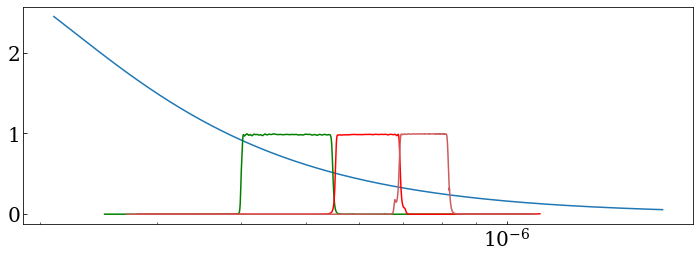

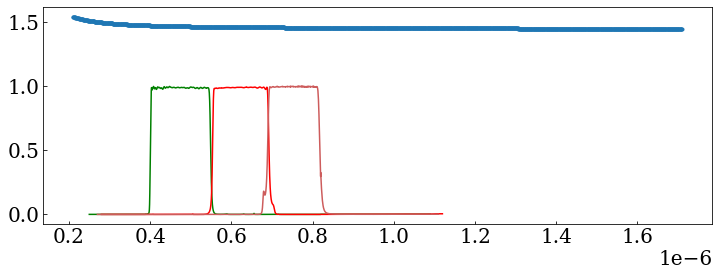

In [3]:
wlarr = np.arange(0.21,1.71,0.001)*1e-6
dsize = 1e-7

plt.figure(figsize=(12,4))
plt.plot(wlarr, hulst(dsize,wlarr))
for f in filt:
    plt.plot(filt_trans[f][0],filt_trans[f][1],c=filt_c[f])
plt.xscale('log')
plt.show()
plt.figure(figsize=(12,4))
plt.plot(wlarr, ref_index(wlarr*1e6),marker='.')
for f in filt:
    plt.plot(filt_trans[f][0],filt_trans[f][1],c=filt_c[f])
#plt.xscale('log')
plt.show()

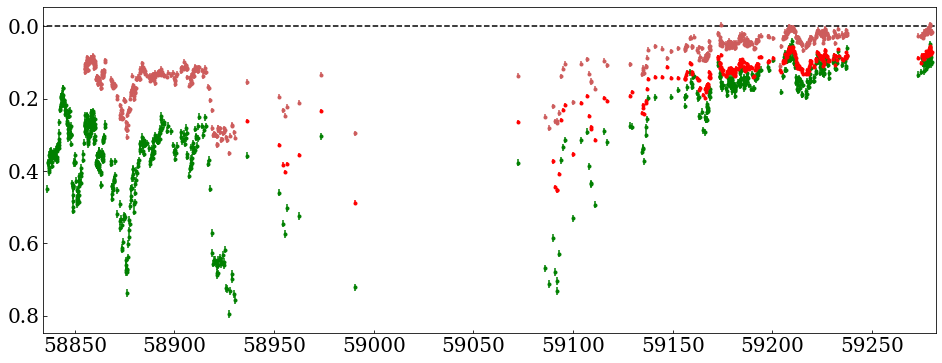

In [4]:
epoch = {}
mag = {}
magerr = {}
for f in filt:
    d = ascii.read('../J0600_mag/LCOGT_'+f+'.txt')
    epoch[f] = np.array(d["EPOCH"])
    mag[f] = np.array(d["NORMMAG"])
    magerr[f] = np.array(d["MAGERR"])

plt.figure(figsize=(16,6))
plt.plot([0,1e6],[0,0],linestyle='--',c='black')
for f in filt:
    plt.errorbar(epoch[f],mag[f],yerr=magerr[f],fmt='.',c=filt_c[f])
plt.xlim(np.min(epoch['gp'])-2,2+np.max(epoch['gp']))
plt.gca().invert_yaxis()
plt.show()


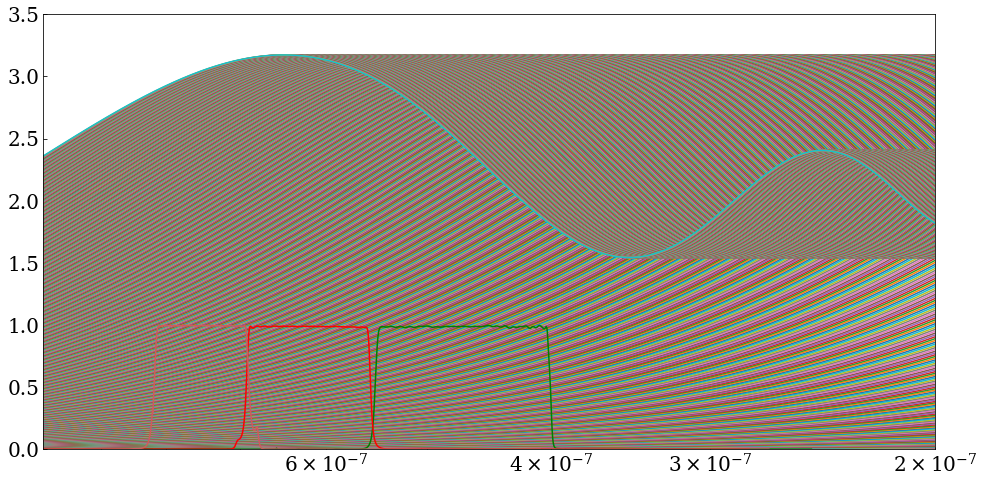

In [58]:
wl_arr = np.arange(200,1000,0.1) * 1e-9 # m
#wl_arr = np.arange(400,860,0.1) * 1e-9 # m

#sizes = np.arange(1,20,2) * 1e-8 #m
#sizes = [20e-8]
sizes = np.logspace(1e-9,2e-7,1000)-1
#sizes = [5e-1, 5e-2, 5e-3,5e-4,5e-5,5e-6,5e-7,5e-8]

#fig, axs = plt.subplots(len(sizes), sharex=True, gridspec_kw={'hspace': 0})
#fig.set_figheight(3*len(sizes))
#fig.set_figwidth(16)
#for i in range(len(sizes)):
#    axs[i].plot(wl_arr,hulst(sizes[i],wl_arr))
#    for f in filt:
#        axs[i].plot(filt_trans[f][0],filt_trans[f][1],c=filt_c[f])
#    axs[i].set_ylim(0,3.5)
#    axs[i].set_yscale('log')
#    axs[i].set_ylim(1e-1,3.5)
#axs[i].set_xscale('log')
#axs[i].set_xlim(np.min(wl_arr),np.max(wl_arr))
#axs[i].invert_xaxis()

# Hide x labels and tick labels for all but bottom plot.
#for ax in axs:
#    ax.label_outer()
#plt.show()

# plt.figure(figsize=(8,5))
# for s in sizes:
#     plt.plot(wl_arr,hulst(s,wl_arr),label="Dust with radius $0.2\mu m$",c='b')
#     plt.ylim(0,3.5)
# #    axs[i].set_yscale('log')
# #    axs[i].set_ylim(1e-1,3.5)
# for f in filt:
#     plt.plot(filt_trans[f][0],filt_trans[f][1],c=filt_c[f],label=f+" bandpass")
# plt.xscale('log')
# plt.xlim(np.min(wl_arr),np.max(wl_arr))
# plt.axis(ymin=0.01,ymax=3.25,xmin=2e-8,xmax=1e-6)
# plt.legend(loc=4)
# plt.ylabel("$Q_t$")
# plt.xlabel("Wavelength ($nm$)")
# plt.title("Anomalous diffraction with LCOGT filters")
# plt.gca().invert_xaxis()
# plt.show()

plt.figure(figsize=(16,8))
for s in sizes:
    plt.plot(wl_arr,hulst(s,wl_arr))
    plt.ylim(0,3.5)
#    axs[i].set_yscale('log')
#    axs[i].set_ylim(1e-1,3.5)
for f in filt:
    plt.plot(filt_trans[f][0],filt_trans[f][1],c=filt_c[f])
plt.xscale('log')
plt.xlim(np.max(wl_arr),np.min(wl_arr))
plt.show()

In [59]:
def mie_ext_func(a,f):
    lamb = (filt_trans[f][0][1:]+filt_trans[f][0][:-1])/2
    dlamb = (filt_trans[f][0][1:]-filt_trans[f][0][:-1])
    trans = (filt_trans[f][1][1:]+filt_trans[f][1][:-1])/2
    return np.sum(hulst(a,lamb)*dlamb*trans) / np.sum(dlamb*trans)

mie_ext = {}
for f in filt:
    tmp = []
    for s in sizes:
        tmp.append(mie_ext_func(s,f))
    mie_ext[f] = np.array(tmp)
    

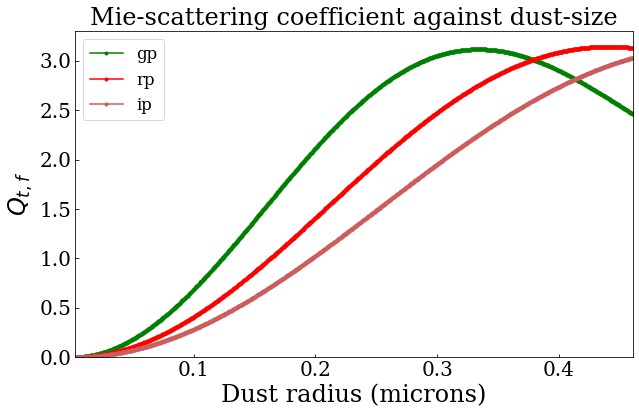

In [60]:
plt.figure(figsize=(10,6))
for f in filt:
    plt.plot(1e6*sizes,mie_ext[f],marker='.',c=filt_c[f],label=f)
plt.xlabel("Dust radius (microns)")
plt.ylabel("$Q_{t,f}$")
plt.title("Mie-scattering coefficient against dust-size")
#plt.xscale('log')
plt.axis(ymin=0,xmin=sizes[0]*1e6,xmax=sizes[-1]*1e6)
plt.legend()
plt.show()

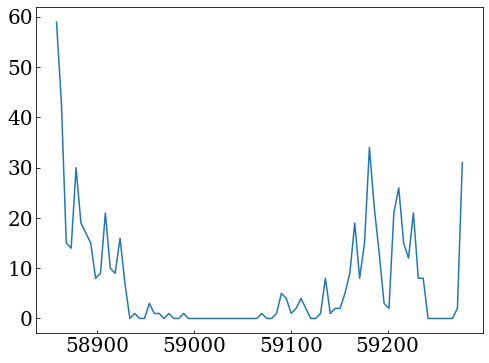

85
[58855.095569   58860.15169292 58865.20781684 58870.26394076
 58875.32006469 58880.37618861 58885.43231253 58890.48843645
 58895.54456037 58900.60068429 58905.65680821 58910.71293214
 58915.76905606 58920.82517998 58925.8813039  58930.93742782
 58935.99355174 58941.04967566 58946.10579959 58951.16192351
 58956.21804743 58961.27417135 58966.33029527 58971.38641919
 58976.44254311 58981.49866704 58986.55479096 58991.61091488
 58996.6670388  59001.72316272 59006.77928664 59011.83541056
 59016.89153449 59021.94765841 59027.00378233 59032.05990625
 59037.11603017 59042.17215409 59047.22827801 59052.28440194
 59057.34052586 59062.39664978 59067.4527737  59072.50889762
 59077.56502154 59082.62114546 59087.67726939 59092.73339331
 59097.78951723 59102.84564115 59107.90176507 59112.95788899
 59118.01401291 59123.07013684 59128.12626076 59133.18238468
 59138.2385086  59143.29463252 59148.35075644 59153.40688036
 59158.46300429 59163.51912821 59168.57525213 59173.63137605
 59178.68749997 59183

In [80]:
Ndays_bin = 5

num, bins = np.histogram(epoch['ip'],np.int((epoch['ip'][-1]-epoch['ip'][0])/Ndays_bin))
plt.plot((bins[1:]+bins[:-1])/2,num)
plt.show()
print (len(bins))

print ((bins))

# e_lim = [0,50,100,150,212]
# for beg, end in zip(e_lim[:-1], e_lim[1:]):
#     plt.figure(figsize=(16,6))
#     plt.plot([0,1e6],[0,0],linestyle='--',c='black')
#     for f in filt:
#         plt.errorbar(epoch[f],mag[f],yerr=magerr[f],fmt='.',c=filt_c[f])

#     for e in bins:
#         plt.plot([e,e],[0,.5],c='black',linewidth=1)
#     plt.xlim(bins[beg]-2,2+bins[end])
#     #plt.xlim(e1-5,5+e2)
#     plt.ylim(-0.05,0.75)
#     plt.gca().invert_yaxis()
#     plt.show()

In [81]:
# Select epochs for interesting parts of the lightcurve\

point = {}
for f in filt:
    tmp = []
    for i in range(len(bins)-1):
        e1, e2 = bins[i:i+2]
    
        m1 = epoch[f]>e1
        m2 = epoch[f]<e2
        if np.sum(m1*m2) != 0:
            w = 1/magerr[f][m1*m2]
            tmp.append(np.sum(mag[f][m1*m2]*w)/np.sum(w))
        else:
            tmp.append(np.nan)
    point[f] = np.array(tmp)

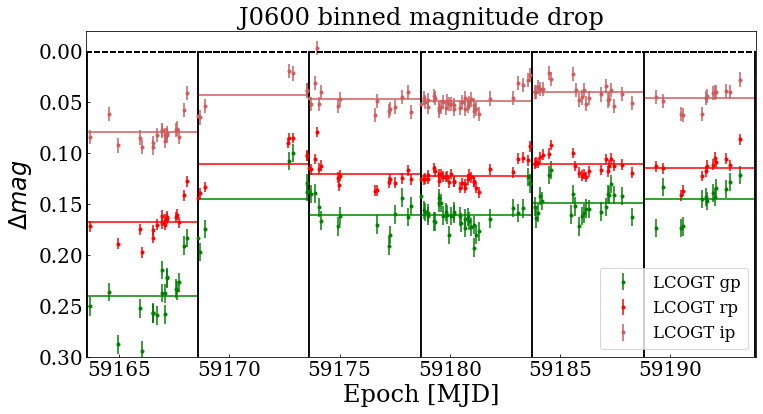

In [82]:
plt.figure(figsize=(12,6))
for i in range(len(bins)-2):
    e1, e2 = bins[i:i+2]
    
    for f in filt:
        plt.plot([e1,e2],[point[f][i]]*2,c=filt_c[f])


    plt.plot([0,1e6],[0,0],linestyle='--',c='black')
    
    for e in [e1,e2]:
        plt.plot([e,e],[0,.5],c='black')
        
for f in filt:
    plt.errorbar(epoch[f],mag[f],yerr=magerr[f],fmt='.',c=filt_c[f],label='LCOGT '+f)
plt.xlim(np.min(epoch['gp'])-2,2+np.max(epoch['gp']))
#plt.xlim(e1-5,5+e2)
plt.title("J0600 binned magnitude drop")
plt.ylabel('$\Delta mag$')
plt.xlabel('Epoch [MJD]')
plt.xlim(59163.505,59193.9)
plt.ylim(-0.02,0.3)
plt.gca().invert_yaxis()
plt.legend(loc=4)
plt.show()

In [83]:
def Nparticles(dmag, a, Q):
    return (1/(np.pi*(a**2)*Q)) * (1-(10**(dmag/(-2.5)))) 

Npar = {}
for f in filt:
    Npar[f] = []

for i in range(len(num)):
    for f in filt:
        Npar[f].append(Nparticles(point[f][i],sizes,mie_ext[f]))
for f in filt:
    Npar[f] = np.array(Npar[f])

In [84]:
# for i in range(len(num)):
#     plt.figure(figsize=(8,6))
#     for f in filt:
#         plt.plot(sizes,Npar[f][i],marker='.',c=filt_c[f])
#     plt.yscale('log')
#     plt.xscale('log')
#     plt.show()

In [85]:
ep = (bins[1:] + bins[:-1])/2

dsize1 = []
dsizeerr1 = []
NP = []
NPerr = []
NP2 = []

for i in range(len(num)):
    tmp = []
    tmp2 = []
    for f1, f2 in zip(['gp','rp','ip'],['rp','ip','gp']):
    #for f1, f2 in zip(['gp'],['ip']):
        dis = np.abs(Npar[f1][i] - Npar[f2][i])
        if np.sum(np.isnan(dis)) == 0:
            i_max = np.where(dis == np.min(dis))[0]

            #plt.plot([1e6*sizes[i_max]]*2, [0,-1e-7],c='black')
            #plt.plot(1e6*sizes,dis,marker='.',label=f1+'-'+f2)
            
            tmp.append(sizes[i_max])
            tmp2.append((Npar[f1][i]+Npar[f2][i])[i_max]/2)
    dsize1.append(np.mean(tmp))
    dsizeerr1.append(np.std(tmp))
    NP.append(np.mean(tmp2))
    NPerr.append(np.std(tmp2))
    NP2.append(Nparticles(point['gp'][i],dsize1[i],mie_ext_func(dsize1[i],'gp')))
            

    #plt.xlabel("Dust size (micrometer)")
    #plt.ylabel("J0600_mag/mie_ext")
    #plt.ylim(-1e-7,2e-7)
    #plt.legend()
    #plt.show()

dsize1 = np.array(dsize1)
dsizeerr1 = np.array(dsizeerr1)
NP = np.array(NP)
NPerr = np.array(NPerr)
NP2 = np.array(NP2)
#print (NP2)
print (np.shape(NP2))
print (np.shape(ep))
print (np.shape(dsizeerr1 != 0))

(84,)
(84,)
(84,)


/home/bartjuh60/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bartjuh60/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/bartjuh60/.local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/bartjuh60/.local/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/bartjuh60/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [86]:
# print (len(num))
# for i in np.arange(len(num))[20:]:
#     if np.isnan(Npar['gp'][i][0]) == False:
#         plt.figure(figsize=(8,4))
#         for f1, f2 in zip(['gp','rp','ip'],['rp','ip','gp']):
#             dis = np.abs(Npar[f1][i] - Npar[f2][i])
#             if np.sum(np.isnan(dis)) == 0:
#                 i_max = np.where(dis == np.min(dis))[0]
#                 plt.plot([1e6*sizes[i_max]]*2, [8e10,5e11],c='black')
#                 #plt.plot(1e6*sizes,dis,label=f1+'-'+f2)
#         for f in filt:
#             if np.sum(np.isnan(Npar[f][i])) == 0:
#                 plt.plot(1e6*sizes,Npar[f][i],label=f,c=filt_c[f])

#         plt.xlabel("Dust radius (micrometer)")
#         plt.ylabel("N particles")
#         plt.yscale('log')
#         plt.ylim(1e11,5e13)
#         plt.xlim(0.08,0.4)
#         plt.title("Dust size calculation demonstration")
#         plt.legend()
#         plt.show()

# for i in np.arange(len(num))[20:]:
#     if np.isnan(Npar['gp'][i][0]) == False:
#         plt.figure(figsize=(12,12))
#         for f1, f2 in zip(['gp','rp','ip'],['rp','ip','gp']):
#             dis = np.abs(Npar[f1][i] - Npar[f2][i])
#             if np.sum(np.isnan(dis)) == 0:
#                 i_max = np.where(dis == np.min(dis))[0]
#                 plt.plot([1e6*sizes[i_max]]*2, [1e12,1e15],c='black')
#                 plt.plot(1e6*sizes,dis,label=f1+'-'+f2)
#         #for f in filt:
#         #    if np.sum(np.isnan(Npar[f][0])) == 0:
#         #        plt.plot(1e6*sizes,Npar[f][i],label=f,c=filt_c[f])

#         plt.xlabel("Dust size (micrometer)")
#         plt.ylabel("J0600_mag/mie_ext")
#         plt.yscale('log')
#         #plt.ylim(0,2e-6)
#         #plt.xlim(0,0.2)
#         plt.title(ep[i])
#         plt.legend()
#         plt.show()


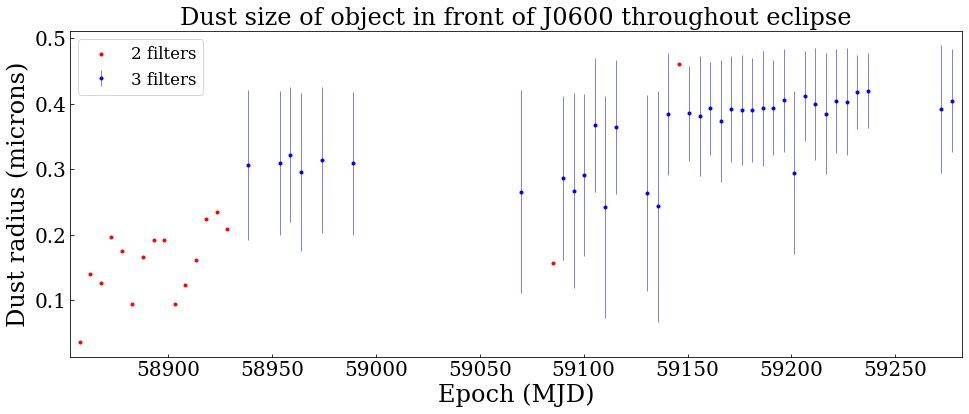

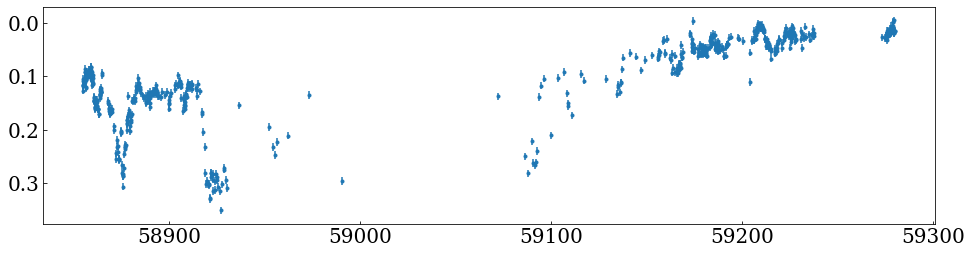

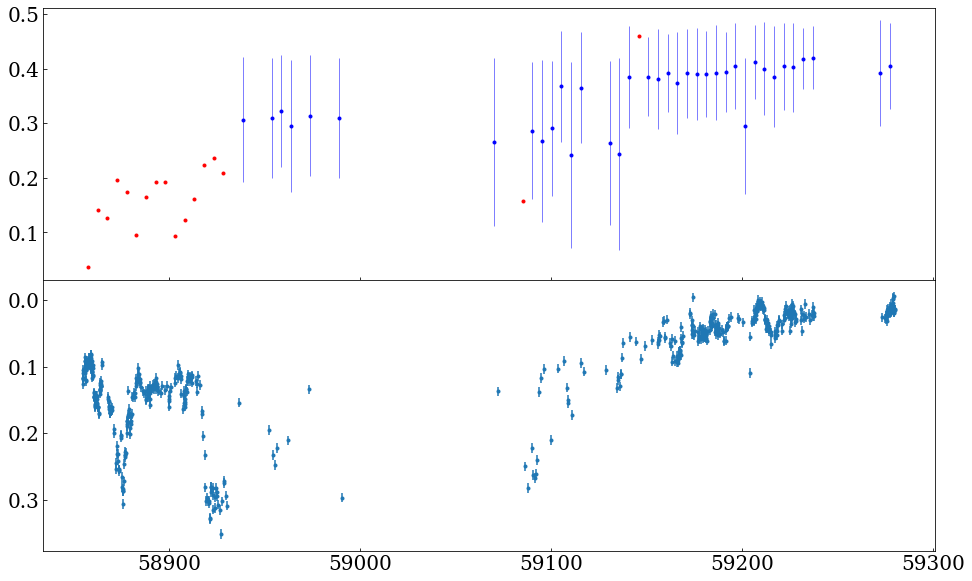

In [87]:
mask = dsizeerr1 != 0

plt.figure(figsize=(16,6))


plt.errorbar(ep[mask], 1e6*dsize1[mask], yerr=1e6*dsizeerr1[mask],fmt='.',c='b',linewidth=.5,label='3 filters')
plt.scatter(ep[mask==False], 1e6*dsize1[mask==False],marker='.',c='r',label='2 filters')
plt.ylabel("Dust radius (microns)")
plt.xlabel("Epoch (MJD)")
plt.title("Dust size of object in front of J0600 throughout eclipse")
#plt.axis(xmin=59100)
plt.xlim(ep[0]-5,5+ep[-1])
plt.legend()
plt.show()
# plt.figure(figsize=(16,4))
# #plt.errorbar(ep, NP2,fmt='.',c='black',markersize=10)
# plt.errorbar(ep[mask], NP[mask], yerr=NPerr[mask], fmt='.',c='b')#,yerr=NPerr[mask])
# plt.errorbar(ep[mask==False], NP[mask==False],fmt='.',c='r')
# plt.ylabel("#particles")
# #plt.axis(xmin=59100)
# plt.xlabel("Epoch (MJD)")
# plt.yscale('log')
# plt.show()
#plt.figure(figsize=(16,8))
#plt.ylabel("#particles")
#plt.xlabel("Epoch (MJD)")
#plt.yscale('log')
#plt.show()
plt.figure(figsize=(16,4))
plt.errorbar(epoch['ip'],mag['ip'],yerr=magerr['ip'],fmt='.')
plt.gca().invert_yaxis()
plt.show()

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
#fig.title('Magnitude of J0600 in gp and rp filter ')
fig.set_figheight(10)
fig.set_figwidth(16)
axs[0].errorbar(ep[mask], 1e6*dsize1[mask], yerr=1e6*dsizeerr1[mask],fmt='.',c='b',linewidth=.5,label='3 filters')
axs[0].scatter(ep[mask==False], 1e6*dsize1[mask==False],marker='.',c='r',label='2 filters')

axs[1].errorbar(epoch['ip'],mag['ip'],yerr=magerr['ip'],fmt='.')
axs[1].invert_yaxis()
#axs[1].set_xlim([epoch['ip'][0]-2,2+epoch['ip']])

In [16]:
NP3 = {}
for f in filt:
    NP3[f] = []
    
for i in range(len(num)):
    for f in filt:
        #NP3[f].append(Nparticles(point[f][i],np.nanmedian(dsize1),mie_ext_func(np.nanmedian(dsize1),f)))
        NP3[f].append(Nparticles(point[f][i],dsize1[i],mie_ext_func(dsize1[i],f)))
for f in filt:
    NP3[f] = np.array(NP3[f])

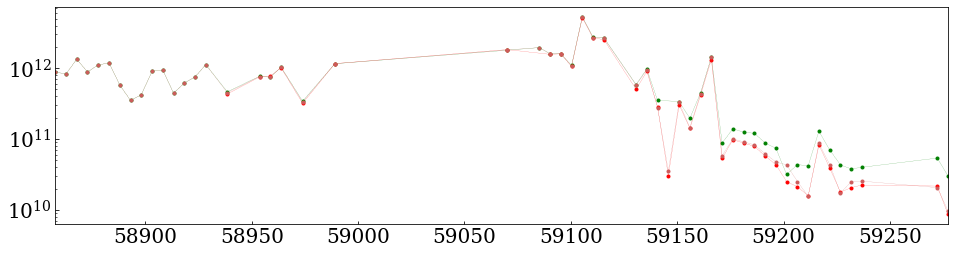

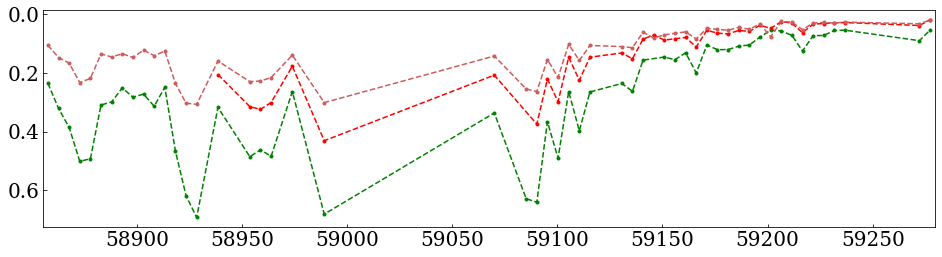

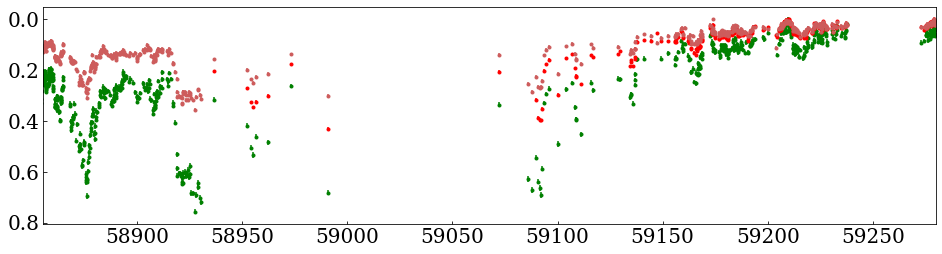

In [17]:
plt.figure(figsize=(16,4))
for f in filt:
    plt.errorbar(ep[np.isnan(point[f])==False],NP3[f][np.isnan(point[f])==False],c=filt_c[f],fmt='--.',linewidth=0.2)
plt.yscale('log')
plt.xlim(ep[0],ep[-1])
plt.show()
plt.figure(figsize=(16,4))
for f in filt:
    plt.errorbar(ep[np.isnan(point[f])==False],point[f][np.isnan(point[f])==False],fmt='--.',c=filt_c[f])
plt.gca().invert_yaxis()
plt.xlim(epoch['ip'][0],epoch['ip'][-1])
plt.show()
plt.figure(figsize=(16,4))
for f in filt:
    plt.errorbar(epoch[f],mag[f],yerr=magerr[f],fmt='.',c=filt_c[f])
plt.gca().invert_yaxis()
plt.xlim(epoch['ip'][0],epoch['ip'][-1])
plt.show()

In [18]:
for f in filt:
    print (mag[f][mag[f]<0])
    print (np.nanmin(point[f]))

[]
0.05369069374035822
[]
0.018325649898619945
[]
0.019442604382963254


In [20]:
stop

NameError: name 'stop' is not defined

In [ ]:
corext = {}
for f in filt:
    corext[f] = []

plt.figure(figsize=(16,16))
for i in range(len(num)):
    corext_tmp = {}
    for f in filt:
        corext_tmp[f] = mie_ext[f]/point[f][i]
        corext[f].append(corext_tmp[f])

    #plt.figure(figsize=(16,10))
    for f in filt:
        plt.plot(sizes*1e6,corext_tmp[f],marker='.',c=filt_c[f])
    plt.xlabel("Dust size (micrometer)")
    plt.ylabel("J0600_mag/mie_ext")
plt.yscale('log')
plt.show()

for f in filt:
    corext[f] = np.array(corext[f])

In [ ]:
canep = (bins[1:] + bins[:-1])/2

dsize = []
dsizeerr = []

for i in range(len(num)):
    tmp = []
    for f1, f2 in zip(['gp','rp','ip'],['rp','ip','gp']):
        dis = np.abs(corext[f1][i] - corext[f2][i])
        if np.sum(np.isnan(dis)) == 0:
            i_max = np.where(dis == np.min(dis))[0]

            #plt.plot([1e6*sizes[i_max]]*2, [0,-1e-7],c='black')
            #plt.plot(1e6*sizes,dis,marker='.',label=f1+'-'+f2)
            
            tmp.append(sizes[i_max])
    dsize.append(np.mean(tmp))
    dsizeerr.append(np.std(tmp))
            

    #plt.xlabel("Dust size (micrometer)")
    #plt.ylabel("J0600_mag/mie_ext")
    #plt.ylim(-1e-7,2e-7)
    #plt.legend()
    #plt.show()

dsize = np.array(dsize)
dsizeerr = np.array(dsizeerr)


In [ ]:
mask = dsizeerr != 0
plt.figure(figsize=(16,8))
plt.errorbar(ep[mask], 1e6*dsize[mask], yerr=1e6*dsizeerr[mask],fmt='.',c='b')
plt.errorbar(ep[mask==False], 1e6*dsize[mask==False], yerr=1e6*dsizeerr[mask==False],fmt='.',c='r')
plt.ylabel("Dust size (micrometers)")
plt.xlabel("Epoch (MJD)")
plt.show()
plt.figure(figsize=(16,4))
plt.errorbar(epoch['ip'],mag['ip'],yerr=magerr['ip'],fmt='.')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
for i in range(len(num))[100:]:
    if np.isnan(corext['gp'][i])[0] == False:
        plt.figure(figsize=(12,12))
        for f1, f2 in zip(['gp','rp','ip'],['rp','ip','gp']):
            dis = np.abs(corext[f1][i] - corext[f2][i])
            if np.sum(np.isnan(dis)) == 0:
                i_max = np.where(dis == np.min(dis))[0]
                plt.plot([1e6*sizes[i_max]]*2, [0,1e-7],c='black')
        #        plt.plot(1e6*sizes,dis,marker='.',label=f1+'-'+f2)
        for f in filt:
            plt.plot(1e6*sizes,corext[f][i],label=f)

        plt.xlabel("Dust size (micrometer)")
        plt.ylabel("J0600_mag/mie_ext")
        #plt.ylim(0,2e-6)
        #plt.xlim(0,0.2)
        plt.title(ep[i])
        plt.legend()
        plt.show()